In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Make sure pandas profiling is installed and Skforecast is installed
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done


In [ ]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import EDA, data manipulation and graphing modules
import pandas as pd
from pandas import read_csv
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Import forecasting modules from Skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.utils import save_forecaster
from sklearn.metrics import mean_squared_error

# Import 9 different regressor models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
#Read the dataset containing annual average temperatures from 1750-2013 for 242 countries
df = pd.read_csv('/content/drive/MyDrive/UC BSE/GlobalTemperatures/GlobalLandTemperaturesByCountry.csv')

In [ ]:
# Asses the dataframe to check that it was loaded correctly
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1744-04-01,1.530,4.680,Åland
2,1744-05-01,6.702,1.789,Åland
3,1744-06-01,11.609,1.577,Åland
4,1744-07-01,15.342,1.410,Åland


In [ ]:
# Asses the dataframe to check that it was loaded correctly
df.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
544806,2013-04-01,21.142,0.495,Zimbabwe
544807,2013-05-01,19.059,1.022,Zimbabwe
544808,2013-06-01,17.613,0.473,Zimbabwe
544809,2013-07-01,17.000,0.453,Zimbabwe
544810,2013-08-01,19.759,0.717,Zimbabwe


In [ ]:
# Asses the dataframes shape to find the entry and attribute counts
df.shape

(544811, 4)

In [ ]:
# Check the attribute specific types
print(df.dtypes)

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
Country                           object
dtype: object


In [ ]:
# Assess the attribute names for later analysis
df.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')

In [ ]:
# Show how many unique countries and dates there are
df.nunique()

dt                                3167
AverageTemperature               52028
AverageTemperatureUncertainty     8979
Country                            242
dtype: int64

In [ ]:
# Assess non-null counts of attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544811 entries, 0 to 544810
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             544811 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  544811 non-null  float64
 3   Country                        544811 non-null  object 
dtypes: float64(2), object(2)
memory usage: 16.6+ MB


In [ ]:
# Check the correlation between avg temp and avg temp uncertainty
print(df.corr(method = 'pearson'))

                               AverageTemperature  \
AverageTemperature                       1.000000   
AverageTemperatureUncertainty           -0.305041   

                               AverageTemperatureUncertainty  
AverageTemperature                                 -0.305041  
AverageTemperatureUncertainty                       1.000000  


<AxesSubplot: title={'center': 'Global Average Temperature and Uncertainty (1745-1750)'}>

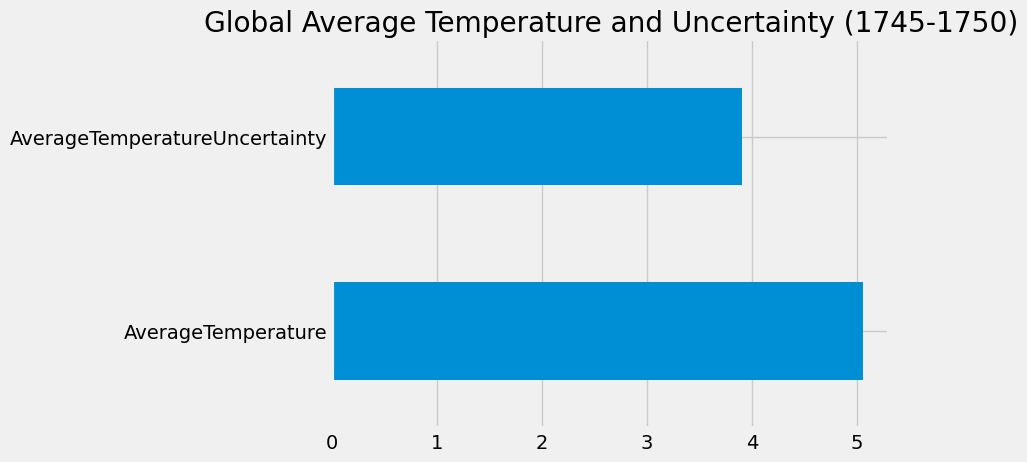

In [ ]:
# EDA Question 1 - What is the global average from the 1750’s and how does it compare to the global average from 2010’s
# Take the first 5 years of the data set (from 1745 to 1750ish for the mean)
earlyDF = df.head(1000)
earlyDF.mean().plot(kind = "barh", legend = False, title = "Global Average Temperature and Uncertainty (1745-1750)")

<AxesSubplot: title={'center': 'Global Average Temperature and Uncertainty (2008-2013)'}>

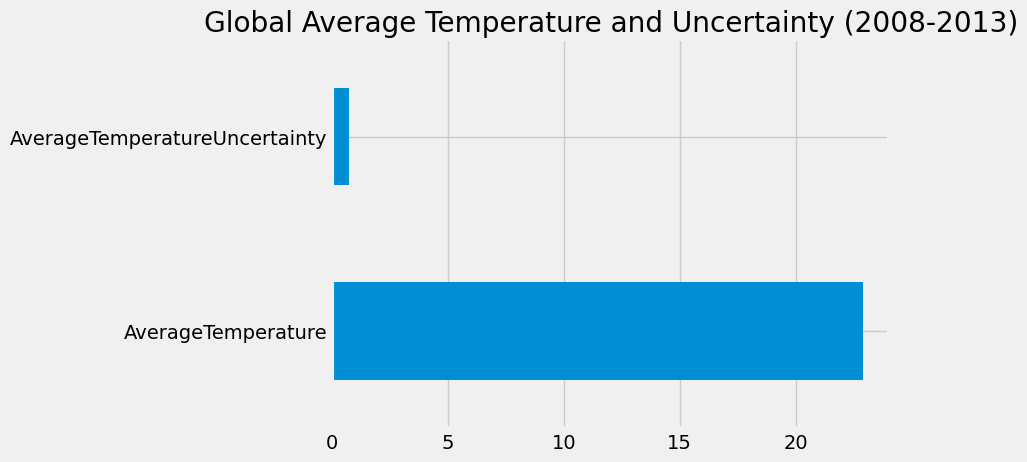

In [ ]:
# Take the last 5 years of the data set (from 2008 to 2013ish for the mean)
lateDF = df.tail(15000)
lateDF.mean().plot(kind = "barh", legend = False, title = "Global Average Temperature and Uncertainty (2008-2013)")

<AxesSubplot: title={'center': 'Top 5 Highest Temperature Uncertainties'}, xlabel='Country'>

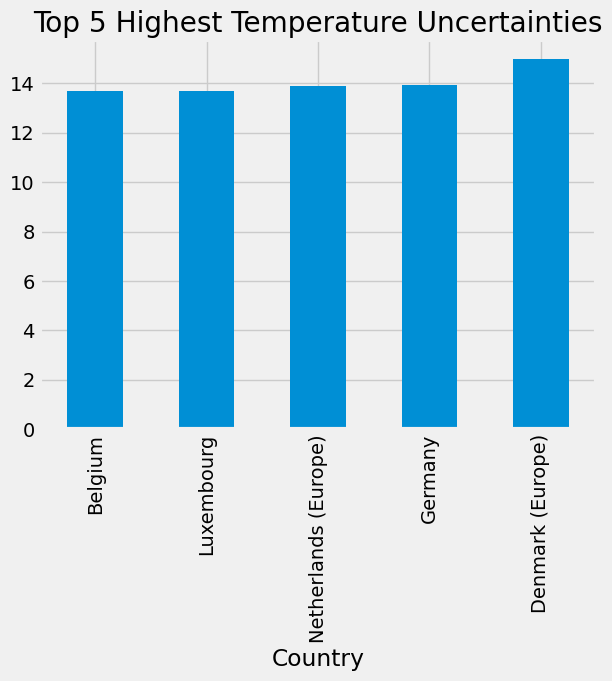

In [ ]:
## EDA Question 2 - reread the dataset to avoid formatting issues
df = pd.read_csv('/content/drive/MyDrive/UC BSE/GlobalTemperatures/GlobalLandTemperaturesByCountry.csv')

# Sort the data by uncertainty to find the highest 5 entries
df = df.sort_values('AverageTemperatureUncertainty')
# Remove duplicates to get the unique countries with the worst uncertainty
uncertaintyDF = df.tail(50).drop_duplicates(subset=['Country'], keep='last')
# Remove the duplicate netherlands entry as they are entered using slightly different names
uncertaintyDF = uncertaintyDF[uncertaintyDF["Country"] != 'Netherlands']

uncertaintyDF.tail(5).plot(x='Country', y='AverageTemperatureUncertainty', kind = "bar", legend = False, title = "Top 5 Highest Temperature Uncertainties")

In [ ]:
uncertaintyDF.tail(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
54561,1768-01-01,-1.586,13.691,Belgium
293718,1768-01-01,-2.413,13.712,Luxembourg
344849,1768-01-01,-1.787,13.907,Netherlands (Europe)
190208,1768-01-01,-5.196,13.954,Germany
130727,1768-01-01,-3.182,15.003,Denmark (Europe)


<AxesSubplot: title={'center': '5 Least Entry Counts'}, xlabel='Country'>

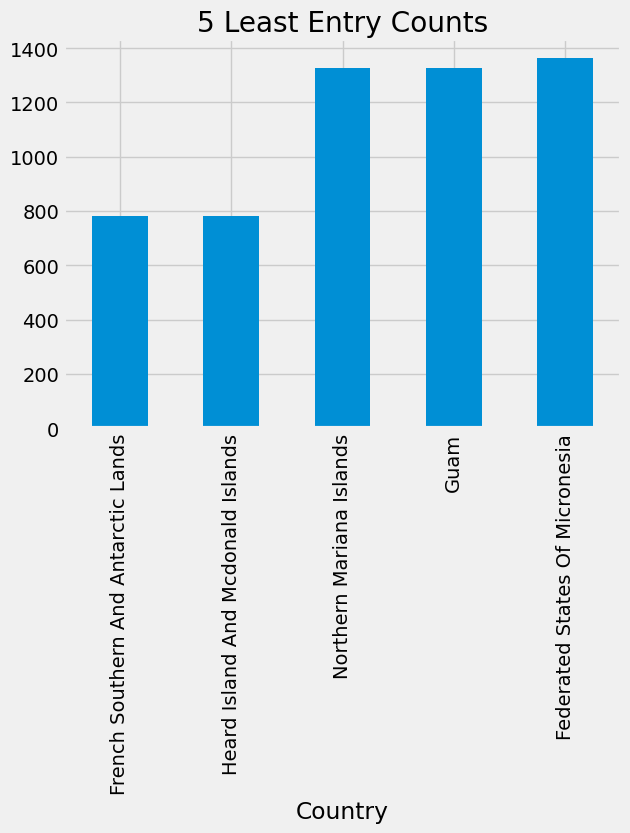

In [ ]:
## EDA Question 3a - reread dataset to avoid formatting issues
df = pd.read_csv('/content/drive/MyDrive/UC BSE/GlobalTemperatures/GlobalLandTemperaturesByCountry.csv')

# Sort the countries by least entry counts and plot the results
countryCountDF = df.groupby(df['Country'], as_index=False).size() 
sortedCountryCount = countryCountDF.sort_values('size') 
leastEntries = sortedCountryCount.head(5) 
leastEntries.plot(x='Country', kind = "bar", legend = False, title = "5 Least Entry Counts")

<AxesSubplot: title={'center': '5 Most Entry Counts'}, xlabel='Country'>

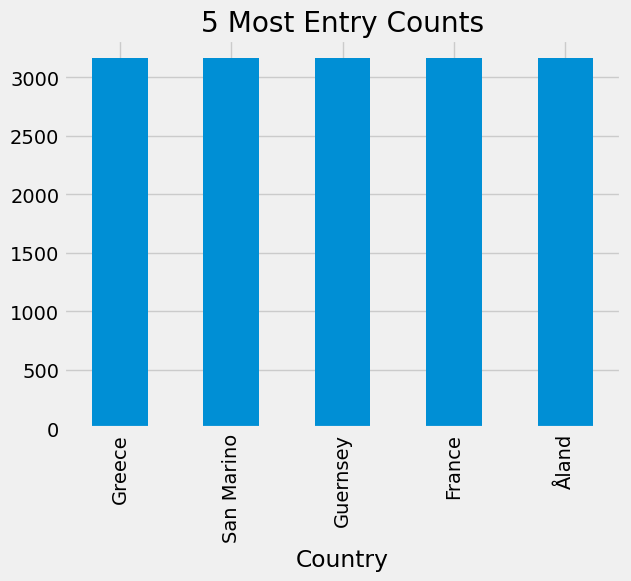

In [ ]:
## EDA Question 3b
mostEntries = sortedCountryCount.tail(5)
mostEntries.plot(x='Country', kind = "bar", legend = False, title = "5 Most Entry Counts")

<AxesSubplot: title={'center': 'Top 5 Highest Temperatures'}, xlabel='Country'>

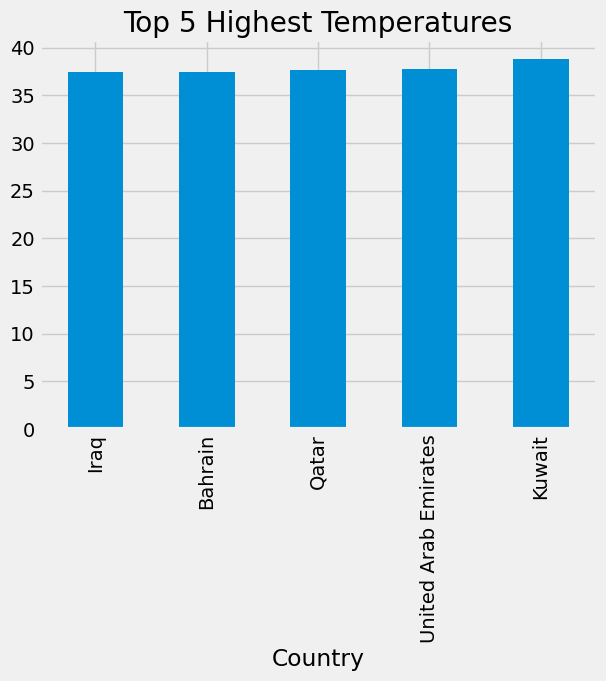

In [ ]:
## EDA Question 4a- reread the dataset to avoid formatting issues
df = pd.read_csv('/content/drive/MyDrive/UC BSE/GlobalTemperatures/GlobalLandTemperaturesByCountry.csv')

# Sort the data by temperature to find the highest and lowest 5 entries
df = df.sort_values('AverageTemperature')
# Remove duplicates to get the unique countries with the max/min values
hottestDF = df.drop_duplicates(subset=['Country'], keep='last').tail(5)
hottestDF.plot(x='Country', y='AverageTemperature', kind = "bar", legend = False, title = "Top 5 Highest Temperatures")

In [ ]:
hottestDF

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
239411,2000-07-01,37.401,0.385,Iraq
44615,2012-07-01,37.471,0.554,Bahrain
401422,2012-07-01,37.603,0.772,Qatar
517801,2010-07-01,37.750,0.571,United Arab Emirates
270679,2012-07-01,38.842,0.464,Kuwait


<AxesSubplot: title={'center': 'Top 5 Lowest Temperatures'}, xlabel='Country'>

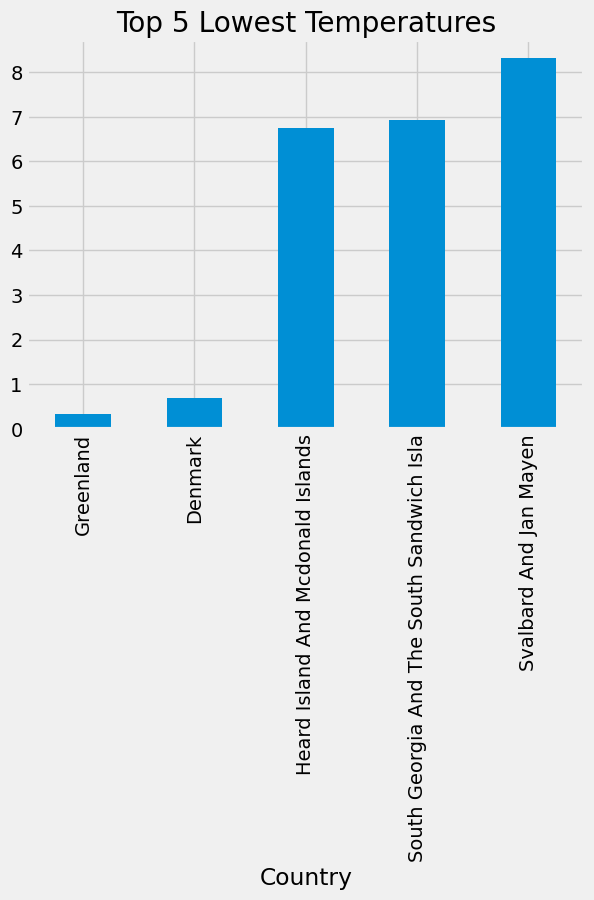

In [ ]:
## EDA Question 4b
coldestDF = df.drop_duplicates(subset=['Country'], keep='last').head(5)
coldestDF.plot(x='Country', y='AverageTemperature', kind = "bar", legend = False, title = "Top 5 Lowest Temperatures")

In [ ]:
coldestDF

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
200331,2009-07-01,0.339,0.499,Greenland
135913,2009-07-01,0.699,0.484,Denmark
220028,2007-01-01,6.736,1.115,Heard Island And Mcdonald Islands
458906,1907-02-01,6.926,4.350,South Georgia And The South Sandwich Isla
471765,1761-07-01,8.308,6.101,Svalbard And Jan Mayen


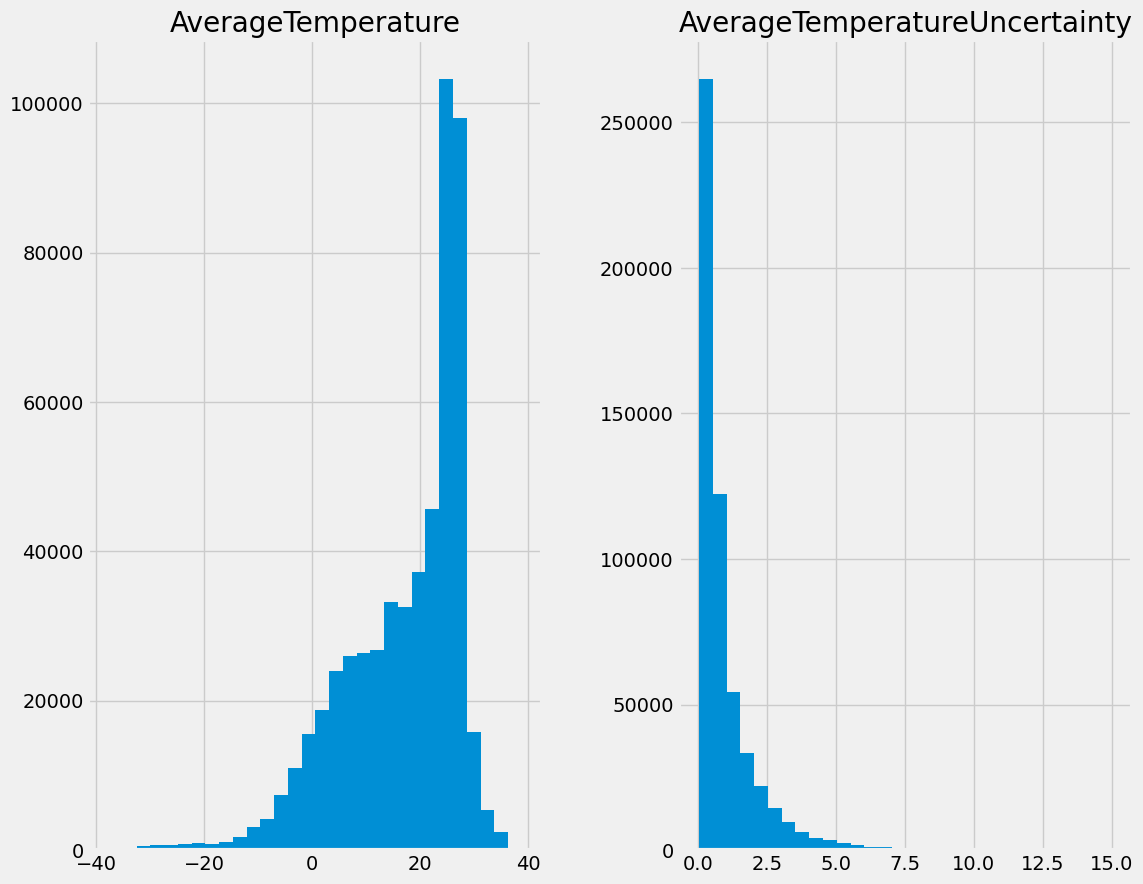

In [ ]:
# Plot the attributes of the global dataframe as histograms
fig = plt.figure(figsize = (12,10))
ax = fig.gca()
df.hist(ax = ax, bins = 30)
plt.show()

In [ ]:
# Reread the dataset to reset formatting
df = pd.read_csv('/content/drive/MyDrive/UC BSE/GlobalTemperatures/GlobalLandTemperaturesByCountry.csv')

# For regression modelling, we need to form unique models for each country being included in the software implementation
# So we will choose Australia as an example country and demonstrate how the regression models will be built for country
# This will be automated in the final implementation
australiaDF = df[df["Country"] == 'Australia']
australiaDF.sort_values(by=['dt'])
australiaDF.head(12)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
32568,1852-07-01,14.116,1.530,Australia
32569,1852-08-01,15.330,1.400,Australia
32570,1852-09-01,18.740,1.446,Australia
32571,1852-10-01,21.984,1.493,Australia
32572,1852-11-01,24.073,1.466,Australia
32573,1852-12-01,26.888,1.840,Australia
32574,1853-01-01,26.953,1.393,Australia
32575,1853-02-01,25.905,1.411,Australia
32576,1853-03-01,24.071,1.596,Australia
32577,1853-04-01,20.587,1.473,Australia


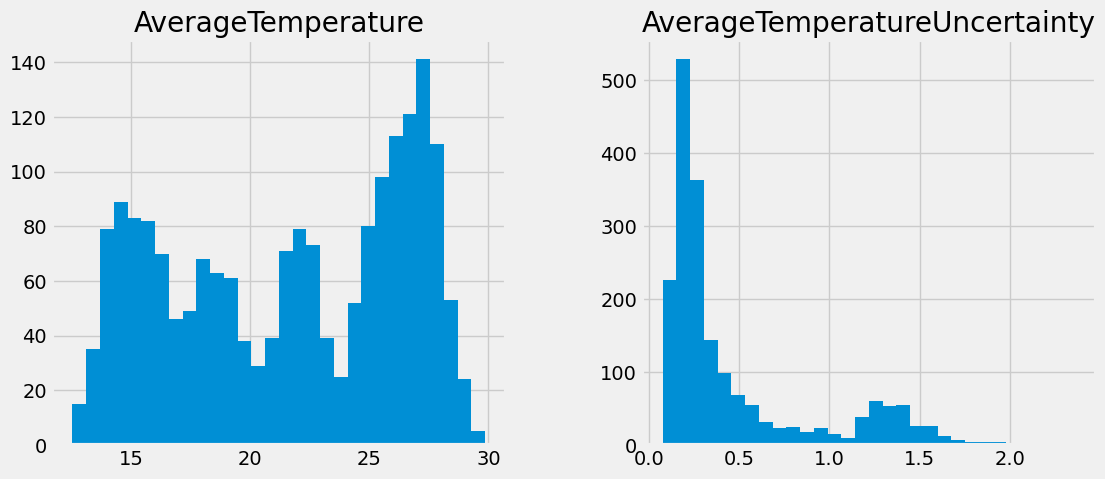

In [ ]:
# Check the attribute distribution of Australia's data
fig = plt.figure(figsize = (12,5))
ax = fig.gca()
australiaDF.hist(ax = ax, bins = 30)
plt.show()

In [ ]:
## EDA Question 5
profile = ProfileReport(df, title='Avg Temp EDA', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# As an example PDA run through, we'll use the Australia subset to visualise and express the process of forecaster training, before automating it across all selectable countries
# Reread the dataset to reset formatting
df = pd.read_csv('/content/drive/MyDrive/UC BSE/GlobalTemperatures/GlobalLandTemperaturesByCountry.csv')
australiaDF = df[df["Country"] == 'Australia']
# Ensure that all dates in the dataset are of the correct format
australiaDF['dt'] = pd.to_datetime(australiaDF['dt'], format='%Y/%m/%d')
# Set the dt attribute as the dataframe index, standardise the frequency to monthly and sort the set by date
australiaDF = australiaDF.set_index('dt')
australiaDF = australiaDF.rename(columns={'x': 'y'})
australiaDF = australiaDF.asfreq('MS', fill_value=0)
australiaDF = australiaDF.sort_index()

# Split the Australian Data in an 80/20 ratio for training/testing
splitIdx = int(len(australiaDF) * 0.2)
trainData = australiaDF[:-splitIdx]
testData  = australiaDF[-splitIdx:]

# Print the year ranges of each data split to check that it is correctly split
print(f"Train dates : {trainData.index.min()} --- {trainData.index.max()}  (n={len(trainData)})")
print(f"Test dates  : {testData.index.min()} --- {testData.index.max()}  (n={len(testData)})")

# Plot the whole australian dataset, with training data in red and testing in blue
fig = go.Figure([
    go.Scatter(
        name='Train Data',
        x=trainData.index,
        y=trainData['AverageTemperature'],
        mode='lines',
        marker=dict(color='red', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Test Data',
        x=testData.index,
        y=testData['AverageTemperature'],
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
])
fig.update_layout(
    yaxis_title="Average National Temperature (\u00B0C)",
    title='Australia Temperature Data Train and Test Split - 80/20',
    hovermode="x")
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()

Train dates : 1852-07-01 00:00:00 --- 1981-06-01 00:00:00  (n=1548)
Test dates  : 1981-07-01 00:00:00 --- 2013-08-01 00:00:00  (n=386)


In [ ]:
# To find the best regressor to use in the Forecaster Auto Regression, we iterate
# through the regressors listed below and choose the one with the lowest mean
# squared error to develop further with hyperparameter tuning and final implementation
regressors = []
regressors.append(('LNR', LinearRegression()))
regressors.append(('RFR', RandomForestRegressor()))
regressors.append(('GBR', GradientBoostingRegressor()))
regressors.append(('KNN', KNeighborsRegressor()))
regressors.append(('DTR', DecisionTreeRegressor()))
regressors.append(('ETR', ExtraTreesRegressor()))
regressors.append(('EN', ElasticNet()))
regressors.append(('LAS', Lasso()))

# Split the Australian Data in an 80/20 ratio for training/testing
splitIdx = int(len(australiaDF) * 0.2)
trainData = australiaDF[:-splitIdx]
testData  = australiaDF[-splitIdx:]

# Initialise tracking variables for best regressor
currentLowestMSE = 100000000
bestRegressor = regressors[0]
lags = 5
# Evaluate each regressor in turn using the Mean Squared Error
for name, regressor in regressors:
  forecaster = ForecasterAutoreg(regressor = regressor, lags = lags)
  forecaster.fit(y=trainData['AverageTemperature'])
  predictions = forecaster.predict(steps=splitIdx)
  error_mse = mean_squared_error(y_true = testData['AverageTemperature'],y_pred = predictions) 
  msg = "%s: %f" % (name, error_mse)
  print(msg)

  # If the MSE of this regressor is better than the current, update bestRegressor
  if error_mse < currentLowestMSE:
    currentLowestMSE = error_mse
    bestRegressor = regressor

msg = f'The best regressor for forecasting was found to be {bestRegressor} and will be improved with hyperparameter tuning.'
print(msg)

LNR: 19.449774
RFR: 1.340272
GBR: 1.126040
KNN: 4.798199
DTR: 1.219550
ETR: 5.780214
EN: 21.267020
LAS: 21.667579
The best regressor for forecasting was found to be GradientBoostingRegressor() and will be improved with hyperparameter tuning.


In [ ]:
# Create a forecaster using the bestRegressor and use it to predict the test data
forecaster = ForecasterAutoreg(regressor = bestRegressor, lags = lags)
forecaster.fit(y=trainData['AverageTemperature'])
predictions = forecaster.predict(steps=splitIdx)

# Plot the training and testing data, with the predictions on top
fig = go.Figure([
    
    go.Scatter(
        name='Train Data',
        x=trainData.index,
        y=trainData['AverageTemperature'],
        mode='lines',
        marker=dict(color='red', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Test Data',
        x=testData.index,
        y=testData['AverageTemperature'],
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Prediction',
        x=predictions.index,
        y=predictions.values,
        mode='lines',
        marker=dict(color='orange', size=2),
        showlegend=True
    )
])
fig.update_layout(
    yaxis_title="Average National Temperature (\u00B0C)",
    title='Australia Temperature Data Train and Test Split - 80/20',
    hovermode="x")
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()

In [ ]:
# Test error
error_mse = mean_squared_error(y_true = testData['AverageTemperature'], y_pred = predictions)
print(f"Actual Error (mse): {error_mse}")

Actual Error (mse): 1.126040341998219


In [ ]:
# Perform hyperparameter tuning on the best regressor to maximise accuracy
forecaster = ForecasterAutoreg(regressor = bestRegressor, lags = lags)

# Regressor's hyperparameters
lags_grid = [5, 10, 20]
param_grid = {'n_estimators': [100, 500], 'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = trainData['AverageTemperature'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = splitIdx,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(trainData)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False)

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [03:01<00:00, 60.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 0.6235342942572794



In [ ]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.623534,10,500
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.626870,5,100
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.671053,10,100
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.680799,5,500
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.824545,3,100
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.836720,3,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",1.647965,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",1.862739,3,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",3.428786,5,500
0,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 100}",3.535186,3,100


In [ ]:
forecaster

ForecasterAutoreg 
Regressor: GradientBoostingRegressor(max_depth=10, n_estimators=500) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1852-07-01 00:00:00'), Timestamp('1981-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
Creation 

In [ ]:
# Refit the forecaster to the training data now it has been tuned
forecaster.fit(y=trainData['AverageTemperature'])
predictions = forecaster.predict(steps=splitIdx)

# Plot the predictions against the actual data using hyper parameter tuning for forecasting
fig = go.Figure([
    
    go.Scatter(
        name='Train Data',
        x=trainData.index,
        y=trainData['AverageTemperature'],
        mode='lines',
        marker=dict(color='red', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Test Data',
        x=testData.index,
        y=testData['AverageTemperature'],
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Prediction Data',
        x=predictions.index,
        y=predictions.values,
        mode='lines',
        marker=dict(color='orange', size=2),
        showlegend=True
    )
])
fig.update_layout(
    yaxis_title="Average National Temperature (\u00B0C)",
    title='Australia Temperature Data Train and Test Split - 80/20',
    hovermode="x")
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()

In [ ]:
# Test error
error_mse = mean_squared_error(y_true = testData['AverageTemperature'], y_pred = predictions)
print(f"Actual Error (mse): {error_mse}")

Actual Error (mse): 1.2204275194028684


In [ ]:
# Save the forecaster
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)

In [ ]:
# Now that we've completed a full PDA on an example country set, we're going to automate the process for multiple selectable countries
# Reread the dataset to reset formatting
df = pd.read_csv('/content/drive/MyDrive/UC BSE/GlobalTemperatures/GlobalLandTemperaturesByCountry.csv')

# For regression modelling, we need to calculate unique forecasters for each country being included in the software implementation
# countryBestRegressors will store the best regressor for each country in the order they appear in countryList
countryList = ['Australia', 'United States', 'United Kingdom', 'Germany', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Denmark', 'Sweden', 'France', 'Spain', 'China', 'Russia']

countryDataframes = []
countryBestRegressors = []

# For each country in the list, perform the same data split and forecaster fitting as we did on the Australia set to find the best regressor for each country
for country in countryList:
  countryDF = df[df["Country"] == country]
  # Ensure that all dates in the dataset are of the correct format
  countryDF['dt'] = pd.to_datetime(countryDF['dt'], format='%Y/%m/%d')
  # Set the dt attribute as the dataframe index, standardise the frequency to monthly and sort the set by date
  countryDF = countryDF.set_index('dt')
  countryDF = countryDF.rename(columns={'x': 'y'})
  countryDF = countryDF.asfreq('MS', fill_value=0)
  countryDF = countryDF.sort_index()

  # Append the formatted countryDF to the list of countryDFs
  countryDataframes.append(countryDF)

  # Split this countries data 80/20
  splitIdx = int(len(countryDF) * 0.2)
  trainData = countryDF[:-splitIdx]
  testData  = countryDF[-splitIdx:]

  # Initialise tracking variables for best regressor
  currentLowestMSE = 100000000
  bestRegressor = regressors[0]
  lags = 5
  # Evaluate each regressor in turn using the Mean Squared Error
  for name, regressor in regressors:
    forecaster = ForecasterAutoreg(regressor = regressor, lags = lags)
    forecaster.fit(y=trainData['AverageTemperature'])
    predictions = forecaster.predict(steps=splitIdx)
    error_mse = mean_squared_error(y_true = testData['AverageTemperature'],y_pred = predictions) 
    msg = "%s: %f" % (name, error_mse)
    print(msg)

    # If the MSE of this regressor is better than the current, update bestRegressor
    if error_mse < currentLowestMSE:
      currentLowestMSE = error_mse
      bestRegressor = regressor

  # Append the best regressor of this country set to the list
  countryBestRegressors.append(bestRegressor)
  msg = f'The best regressor for {country} was found to be {bestRegressor} and will be improved with hyperparameter tuning.'
  print(msg)

LNR: 19.449774
RFR: 1.346616
GBR: 1.126040
KNN: 4.798199
DTR: 1.219550
ETR: 7.428100
EN: 21.267020
LAS: 21.667579
The best regressor for Australia was found to be GradientBoostingRegressor() and will be improved with hyperparameter tuning.
LNR: 81.015064
RFR: 1.526988
GBR: 1.403038
KNN: 1.706465
DTR: 1.796728
ETR: 1.586779
EN: 82.203084
LAS: 82.300605
The best regressor for United States was found to be GradientBoostingRegressor() and will be improved with hyperparameter tuning.
LNR: 15.166413
RFR: 3.125162
GBR: 1.893732
KNN: 39.718561
DTR: 16.513060
ETR: 1.892853
EN: 15.303823
LAS: 15.373103
The best regressor for United Kingdom was found to be ExtraTreesRegressor() and will be improved with hyperparameter tuning.
LNR: 41.426915
RFR: 29.656652
GBR: 3.931370
KNN: 32.192652
DTR: 19.421203
ETR: 65.030054
EN: 42.421298
LAS: 42.876493
The best regressor for Germany was found to be GradientBoostingRegressor() and will be improved with hyperparameter tuning.
LNR: 45.630475
RFR: 3.535363
GBR:

In [ ]:
# Now that the best regressor has been found for each country, iterate through each and hypertune them to their respective countryDataframe
index = 0
countryForecasters = []
for countryDF in countryDataframes:
  # Split this countries data 80/20
  splitIdx = int(len(countryDF) * 0.2)
  trainData = countryDF[:-splitIdx]
  testData  = countryDF[-splitIdx:]

  forecaster = ForecasterAutoreg(regressor = countryBestRegressors[index], lags = lags)
  # Regressor's hyperparameters
  lags_grid = [5, 10, 20]
  
  if isinstance(countryBestRegressors[index], SVR):
    param_grid = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
  else:
    param_grid = {'n_estimators': [100, 500], 'max_depth': [3, 5, 10]}

  results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = trainData['AverageTemperature'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = splitIdx,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(trainData)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False)
  # Append this countries tuned forecaster to the list of country forecasters
  countryForecasters.append(forecaster)
  index += 1

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [02:54<00:00, 58.10s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 0.6322096640970579

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [03:30<00:00, 70.10s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 1.0823454966346815

Number of models compared: 18.


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [11:40<00:00, 233.44s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1.412046713813854

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [04:50<00:00, 96.95s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 3.2813850442749706

Number of models compared: 18.


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [14:19<00:00, 286.57s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 3.214376451418

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [04:51<00:00, 97.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 3.041376802891717

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:51<00:00, 37.06s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.46466775329577215

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [03:24<00:00, 68.13s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 2.575793210503713

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [03:27<00:00, 69.22s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 3.91447635087783

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [04:49<00:00, 96.37s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 4.167637130325069

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [04:49<00:00, 96.47s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 1.5102369839713496

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [04:52<00:00, 97.35s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 1.343351192356091

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [03:11<00:00, 63.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.8243192649526261

Number of models compared: 18.


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [08:32<00:00, 170.78s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 2.2846672353167143



In [ ]:
for forecaster in countryForecasters:
  print(forecaster)

ForecasterAutoreg 
Regressor: GradientBoostingRegressor(max_depth=10, n_estimators=500) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1852-07-01 00:00:00'), Timestamp('1981-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
Creation 

In [ ]:
# Check the mean squared error of each country's forecaster
index = 0
for country in countryList:
  countryDF = df[df["Country"] == country]
  # Ensure that all dates in the dataset are of the correct format
  countryDF['dt'] = pd.to_datetime(countryDF['dt'], format='%Y/%m/%d')
  # Set the dt attribute as the dataframe index, standardise the frequency to monthly and sort the set by date
  countryDF = countryDF.set_index('dt')
  countryDF = countryDF.rename(columns={'x': 'y'})
  countryDF = countryDF.asfreq('MS', fill_value=0)
  countryDF = countryDF.sort_index()

  # Split this countries data 80/20
  splitIdx = int(len(countryDF) * 0.2)
  trainData = countryDF[:-splitIdx]
  testData  = countryDF[-splitIdx:]

  predictions = countryForecasters[index].predict(steps=splitIdx)
  error_mse = mean_squared_error(y_true = testData['AverageTemperature'],y_pred = predictions) 
  msg = "%s: %f" % (country, error_mse)
  print(msg)


  index += 1

Australia: 1.222240
United States: 1.281793
United Kingdom: 1.666864
Germany: 3.827238
Austria: 3.529155
Belgium: 3.273775
Brazil: 0.809066
Canada: 4.039762
Denmark: 4.112852
Sweden: 5.879079
France: 2.150793
Spain: 2.040538
China: 1.703502
Russia: 3.910389


In [ ]:
# Iterate through all the countries and serialise their forecaster out in the format CountryName_forecaster.py
index = 0
for country in countryList:
  save_forecaster(countryForecasters[index], file_name=f'{country}_forecaster.py', verbose=False)
  index += 1